 1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
  1. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
  1. Построить случайный лес, вывести важность признаков
  1. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
  1. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
  1. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
  1. В качестве решения: Jupyter notebook с кодом, комментариями и графиками, ссылка на гитхаб

In [1]:
import numpy as np
import pandas as pd
import sys
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

 Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float64(108), int64(6), object(19)
memory usage: 116.0+ MB


In [4]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


 Исследуем столбцы object, следует ли их перобразовать через one-hot-encoding

In [5]:
df_objects = data[data.select_dtypes(np.object).columns]
pd.DataFrame(
    [(c, df_objects[c].hasnans, len(df_objects[c].unique())) for c in df_objects.columns],
    columns=["Имя столбца", "Есть ли пропуски", "Количество уникальных значений"])

,Имя столбца,Есть ли пропуски,Количество уникальных значений
0,v3,True,4
1,v22,True,18211
2,v24,False,5
3,v30,True,8
4,v31,True,4
5,v47,False,10
6,v52,True,13
7,v56,True,123
8,v66,False,3
9,v71,False,9


 Для one hote encoding возьмем все столбцы для которых количество уникальных значений < 40. Для оставшихся применим LabelEncoding. Пропуски заменим на предопределенное значение 'NAN'

In [6]:
object_columns_ohe = [c for c in df_objects.columns if len(df_objects[c].unique()) < 40]
print(object_columns_ohe)

['v3', 'v24', 'v30', 'v31', 'v47', 'v52', 'v66', 'v71', 'v74', 'v75', 'v79', 'v91', 'v107', 'v110', 'v112', 'v113']


In [7]:
object_columns_le = [c for c in df_objects.columns if c not in object_columns_ohe]
print(object_columns_le)

['v22', 'v56', 'v125']


 Также посмотрим на числовые фичи

In [8]:
df_number = data[data.select_dtypes(np.number).columns]
pd.DataFrame(
    [(c, df_number[c].hasnans, df_number[c].dtype) for c in df_number.columns],
    columns=["Имя столбца", "Есть ли пропуски", "Тип"])

,Имя столбца,Есть ли пропуски,Тип
0,ID,False,int64
1,target,False,int64
2,v1,True,float64
3,v2,True,float64
4,v4,True,float64
...,...,...,...
109,v127,True,float64
110,v128,True,float64
111,v129,False,int64
112,v130,True,float64


 target откладываем отдельно. ID столбец нам не нужен, его отбрасываем. Пропуски для числовых значений будем заполнять медианным значением. Полученное пространство фич нормализуем

In [9]:
object_columns_num = [c for c in df_number.columns if c not in ['target', 'ID']]
print(object_columns_num)

['v1', 'v2', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v23', 'v25', 'v26', 'v27', 'v28', 'v29', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v48', 'v49', 'v50', 'v51', 'v53', 'v54', 'v55', 'v57', 'v58', 'v59', 'v60', 'v61', 'v62', 'v63', 'v64', 'v65', 'v67', 'v68', 'v69', 'v70', 'v72', 'v73', 'v76', 'v77', 'v78', 'v80', 'v81', 'v82', 'v83', 'v84', 'v85', 'v86', 'v87', 'v88', 'v89', 'v90', 'v92', 'v93', 'v94', 'v95', 'v96', 'v97', 'v98', 'v99', 'v100', 'v101', 'v102', 'v103', 'v104', 'v105', 'v106', 'v108', 'v109', 'v111', 'v114', 'v115', 'v116', 'v117', 'v118', 'v119', 'v120', 'v121', 'v122', 'v123', 'v124', 'v126', 'v127', 'v128', 'v129', 'v130', 'v131']


In [10]:
X = data[data.columns[~data.columns.isin(['target', 'ID'])]]
y = data.target

 Состоявляем конвеер преобразующий данные

In [11]:
data_preparation_pipeline = ColumnTransformer([
    (
        "ohe",
        Pipeline([
            ("imp", SimpleImputer(strategy='constant', fill_value="NAN")),
            ("enc", OneHotEncoder(sparse=False))
        ]),
        object_columns_ohe
    ),
    (
        "le",
        Pipeline([
            ("imp", SimpleImputer(strategy='constant', fill_value="NAN")),
            ("enc", OrdinalEncoder()),
        ]),
        object_columns_le
    ),
    (
        "num",
        Pipeline([
            ("imp", SimpleImputer(strategy='median')),
            ("scl", StandardScaler())
        ]),
        object_columns_num
    )
])

In [12]:
%%time

X_prepared = data_preparation_pipeline.fit_transform(X, y)

Wall time: 4.69 s


In [13]:
X_prepared_names = list(data_preparation_pipeline.named_transformers_["ohe"]["enc"].get_feature_names(object_columns_ohe))
X_prepared_names.extend(object_columns_le)
X_prepared_names.extend(object_columns_num)

In [14]:
print(X_prepared_names)

['v3_A', 'v3_B', 'v3_C', 'v3_NAN', 'v24_A', 'v24_B', 'v24_C', 'v24_D', 'v24_E', 'v30_A', 'v30_B', 'v30_C', 'v30_D', 'v30_E', 'v30_F', 'v30_G', 'v30_NAN', 'v31_A', 'v31_B', 'v31_C', 'v31_NAN', 'v47_A', 'v47_B', 'v47_C', 'v47_D', 'v47_E', 'v47_F', 'v47_G', 'v47_H', 'v47_I', 'v47_J', 'v52_A', 'v52_B', 'v52_C', 'v52_D', 'v52_E', 'v52_F', 'v52_G', 'v52_H', 'v52_I', 'v52_J', 'v52_K', 'v52_L', 'v52_NAN', 'v66_A', 'v66_B', 'v66_C', 'v71_A', 'v71_B', 'v71_C', 'v71_D', 'v71_F', 'v71_G', 'v71_I', 'v71_K', 'v71_L', 'v74_A', 'v74_B', 'v74_C', 'v75_A', 'v75_B', 'v75_C', 'v75_D', 'v79_A', 'v79_B', 'v79_C', 'v79_D', 'v79_E', 'v79_F', 'v79_G', 'v79_H', 'v79_I', 'v79_J', 'v79_K', 'v79_L', 'v79_M', 'v79_N', 'v79_O', 'v79_P', 'v79_Q', 'v79_R', 'v91_A', 'v91_B', 'v91_C', 'v91_D', 'v91_E', 'v91_F', 'v91_G', 'v91_NAN', 'v107_A', 'v107_B', 'v107_C', 'v107_D', 'v107_E', 'v107_F', 'v107_G', 'v107_NAN', 'v110_A', 'v110_B', 'v110_C', 'v112_A', 'v112_B', 'v112_C', 'v112_D', 'v112_E', 'v112_F', 'v112_G', 'v112_H', 

In [15]:
X.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.050328,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [16]:
pd.DataFrame(X_prepared, columns=X_prepared_names).head()

,v3_A,v3_B,v3_C,v3_NAN,v24_A,v24_B,v24_C,v24_D,v24_E,v30_A,...,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.750960,0.896493,-0.605014,-0.337299,0.413424,-0.004516,0.112555,-0.447372,-1.168806,1.383783
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.165128,-0.030647,-0.227398,0.006585,-0.086113,-0.126661,0.031739,-0.447372,-0.213300,-0.098853
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.356860,1.884745,-0.359227,-0.350918,0.333169,0.653389,-0.986483,2.437555,-0.913577,-0.581781
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.631055,0.168835,-0.694188,-0.357747,-0.612689,-0.134179,0.071894,0.995092,-0.092312,-0.747838
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.165128,-0.030647,-0.227398,-0.273724,-0.086113,-0.126661,-0.162077,-0.447372,-0.213300,-0.098853


 Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей.
 Построить случайный лес, вывести важность признаков

In [17]:
rf_regressor = RandomForestRegressor(n_estimators=10, max_depth=10)

In [18]:
%%time

rf_cv_score = cross_val_score(rf_regressor, X_prepared, y, cv=10, verbose=10, n_jobs=-1)
rf_cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  4.6min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  4.6min remaining:  2.0min


Wall time: 6min 9s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.2min finished


array([0.14975159, 0.14465412, 0.13996896, 0.15342286, 0.1502312 ,
       0.14615376, 0.14218301, 0.1485105 , 0.14611086, 0.15267731])

In [19]:
print("Mean RF score(SME):", np.mean(rf_cv_score))

Mean RF score(SME): 0.14736641598135738


In [20]:
%%time

rf_regressor.fit(X_prepared, y)

Wall time: 1min 31s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [21]:
feature_importances_list = list(zip(X_prepared_names, rf_regressor.feature_importances_))
feature_importances_list.sort(key=lambda x: x[1], reverse=True)

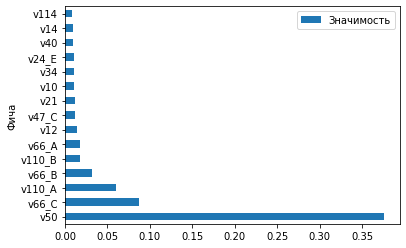

In [22]:
feature_importance_columns=['Фича', 'Значимость']
pd.DataFrame(feature_importances_list, columns=feature_importance_columns).head(15).plot.barh(*feature_importance_columns)
plt.show()

 Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную.
 Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии

In [23]:
class StackingCVRegressor(RegressorMixin, TransformerMixin):
    """Регрессор реализующий stacking стратегию ансамблирования.

    Параметры
    ----------
    regressors : список регрессоров, вырабатывающих метапризнаки
    meta_regressor : метарегрессор, вырабатывающий прогнозы на основе мета признаков
    cv : int, количество разбиений при cv прогнозировании метапризнаков
    shuffle : bool, optional (default: False)
        Нужно ли перемешивать данные перед разбиением
    random_state : int, (default: None)
        Контролирует начальное состояние генератора случайных чисел для разбиения на фолды.
        Используется только если shuffle=True
    verbose : int, optional (default=0)
        Трассирование процесса обучения
    n_jobs : int or None, optional (default=None)
        Количество процессоров на которых будет осуществляться обучения. -1 на всех доступных
    """

    def __init__(self, regressors, meta_regressor, cv=5,
                 shuffle=False, random_state=None, verbose=0,
                 n_jobs=None):

        self.regressors = regressors
        self.meta_regressor = meta_regressor
        self.cv = cv
        self.shuffle = shuffle
        self.random_state = random_state
        self.verbose = verbose
        self.n_jobs = n_jobs

    def _print(self, msg, msg_args=None):
        if not self.verbose:
            return
        if self.verbose < 50:
            writer = sys.stderr.write
        else:
            writer = sys.stdout.write
        msg = msg if msg_args is None else msg % msg_args
        writer('[%s]: %s\n' % (self, msg))
        
    def _cross_val_predict(self, regressor, X, y, cv):
        self._print("Predict meta using ''%s' regressor", regressor.__class__.__name__)
        return cross_val_predict(regressor, X, y, cv=cv,
                verbose=self.verbose, n_jobs=self.n_jobs)
    
    def fit(self, X, y):
        # Для регресси выбираем обычный KFold
        kfold = KFold(self.cv, self.shuffle, self.random_state)
        
        # Формируем признаки размерностью [n_samples, regressors_count]
        meta_features = np.column_stack([
            self._cross_val_predict(regressor, X, y, kfold)
                    for regressor in self.regressors])

        self._print("Fit meta regressor '%s'", self.meta_regressor.__class__.__name__)
        # Обучаем метарегрессор
        self.meta_regressor.fit(meta_features, y)

        self._print("Preparing regressors for further prediction")
        # Обучаем регрессоры на данных для того чтобы работал predict всей модели
        for regressor in self.regressors:
            self._print("prepare '%s' regressor", regressor.__class__.__name__)
            regressor.fit(X, y)

        return self

    def predict(self, X):
        # Получаем метапризнаки
        meta_features = np.column_stack([regressor.predict(X) for regressor in self.regressors])

        # Скармливаем полученные признаки метамодели
        return self.meta_regressor.predict(meta_features)



In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_prepared, y, test_size=0.2)

In [25]:
# Регрессоры вырабатывающие мета фичи
stacking_regressors = [
    # Линейная регрессия с регулиризацией Лассо
    Lasso(alpha=1.0),
    # Обычный SVM
    LinearSVR(C=1.0),
    # Дерево решений
    DecisionTreeRegressor(max_depth=10),
    # Регрессия на основе ближайших соседей
    KNeighborsRegressor(n_neighbors=5)
]

# Мета регрессор
stacking_meta_regressor = SGDRegressor()

In [26]:
%%time

stk_regressor = StackingCVRegressor(stacking_regressors, stacking_meta_regressor, cv=10, verbose=10, n_jobs=-1)
stk_regressor.fit(X_train, y_train)

[<__main__.StackingCVRegressor object at 0x0000000005351048>]: Predict meta using ''Lasso' regressor
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    4.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.6s finished
[<__main__.StackingCVRegressor object at 0x0000000005351048>]: Predict meta using ''LinearSVR' regressor
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.8min finished
[<__main__.StackingCVRegressor object at 0x0000000005351048>]: Predict meta using ''DecisionTreeRegressor' regressor
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 con

Wall time: 6min 22s


 Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)

In [27]:
%%time

regressors_quality = [(regressor.__class__.__name__, mean_squared_error(y_val, regressor.predict(X_val)))
                      for regressor in [stk_regressor, *stacking_regressors]]

Wall time: 10.7 s


In [28]:
pd.DataFrame(regressors_quality, columns=['Регрессор', 'MSE'])

,Регрессор,MSE
0,StackingCVRegressor,0.160463
1,Lasso,0.180854
2,LinearSVR,0.205864
3,DecisionTreeRegressor,0.164679
4,KNeighborsRegressor,0.207384


По результирующей таблице видим что stacking в целом улучшает качество ансамбля по отношению к отдельным моделям.

 В качестве решения: Jupyter notebook с кодом, комментариями и графиками, ссылка на гитхаб